## Problem 3: CPI and BER Data Analysis

The goal of this problem is to analyze the CPI and BER data for the last decade. The CPI (consumer price index, the price of a "market basket of consumer goods and services" - a proxy for inflation) is released monthly by the Bureau of Labor Statistics, and is given in `CPI.csv`. The file `T10YIE.csv` lists (during most of the same time period) the break-even rate (BER) , or the difference in yield between a fixed rate and inflation adjusted 10 year treasury note. This difference can be interpreted as what the market views will be the inflation rate for the next 10 years, on average.

There is more than a decade of data in `CPI.csv`. For your results to the problems below, report the mean squared prediction error for 1 month ahead forecasts starting September 2013. For example, to predict the CPI in May 2015, you can use all the data before May 2015. You should perform all of your model fitting on the months prior to September 2013, and use the remaining months for evaluation.

Additional References:

- The Consumer Price Index (CPI) is a measure of the average change over time in the prices paid by urban consumers for a market basket of consumer goods and services. To read more, visit https://www.bls.gov/cpi.
- As explained in the question above, BER is the difference in yield between a fixed rate and inflation adjusted 10 year treasury note. This difference can be interpreted as what the market views will be the inflation rate for the next 10 years, on average. To read more, visit http://www.bondeconomics.com/2014/05/primer-what-is-breakeven-inflation.html.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
import seaborn as sns

# Set the seaborn style
sns.set()


c:\Users\eddysanoli\AppData\Local\pypoetry\Cache\virtualenvs\data_analysis-ayydRhdv-py3.9\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


### Loading Data


CPI Columns ['date', 'CPI']
BER Columns ['DATE', 'T10YIE']

Full CPI Data Shape: (4122, 2)
Monthly CPI Data Shape: (136, 2)


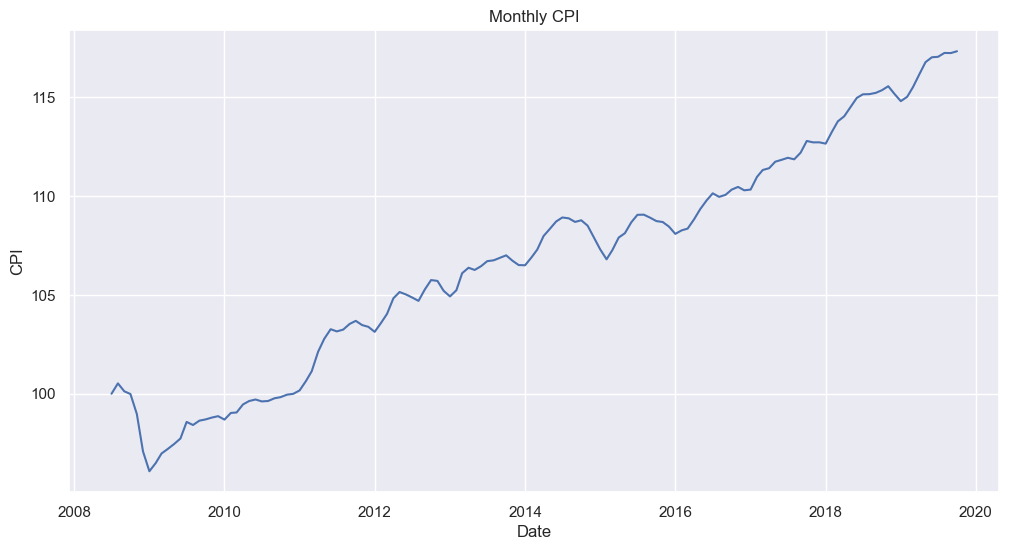

In [2]:
# Load the CPI data
df_cpi = pd.read_csv(
    './Datasets/CPI.csv',
    parse_dates=['date'],
)

# Print the columns of each dataframe
print("CPI Columns", list(df_cpi.columns))
print()

# Take the first CPI value of each month as that month's CPI
# (The element that does the trick here is the "freq='MS'" argument
# which tells the grouper to group by month start)
grouped_df_cpi = df_cpi.groupby(pd.Grouper(key='date', freq='MS')).first()

# Flatten the grouped_df_cpi dataframe to have two columns again
df_cpi_monthly = grouped_df_cpi.reset_index()

# Remove nan values from the CPI data
df_cpi_monthly = df_cpi_monthly.dropna()

# Print the shapes of the dataframes
print("Full CPI Data Shape:", df_cpi.shape)
print("Monthly CPI Data Shape:", df_cpi_monthly.shape)

# ==================== ARRAY =================== #

# Create an additional column for the array that contains the row index
cpi_indexes = np.arange(0, df_cpi_monthly.shape[0])

# Turn the CPI data into an array
cpi_array = df_cpi_monthly.values

# Add the CPI indexes to the array
cpi_array = np.hstack((cpi_indexes.reshape(-1, 1), cpi_array))

# ==================== PLOT ==================== #

plt.figure(figsize=(12, 6))
plt.plot(df_cpi_monthly['date'], df_cpi_monthly['CPI'])
plt.title('Monthly CPI')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.show()


### Train Test Split


In [3]:
# The CPI data is split in the following way:
# - Training data spans from July 2008 to August 2013
# - Test data spans from September 2013 to October 2019
train_end_date = '2013-08-01'
test_start_date = '2013-09-01'

# Convert the dates to datetime objects
train_end_date = pd.to_datetime(train_end_date)
test_start_date = pd.to_datetime(test_start_date)

# Create the training data
train_data = cpi_array[cpi_array[:, 1] < train_end_date]
test_data = cpi_array[cpi_array[:, 1] >= test_start_date]

# Divide the data into X and y
X_train = train_data[:, 0].reshape(-1, 1)
y_train = train_data[:, 2].reshape(-1, 1)
X_test = test_data[:, 0].reshape(-1, 1)
y_test = test_data[:, 2].reshape(-1, 1)


### Detrend CPI


Intercept (alpha 0) 96.73595325224746
Slope (alpha 1) 0.16071213749338967


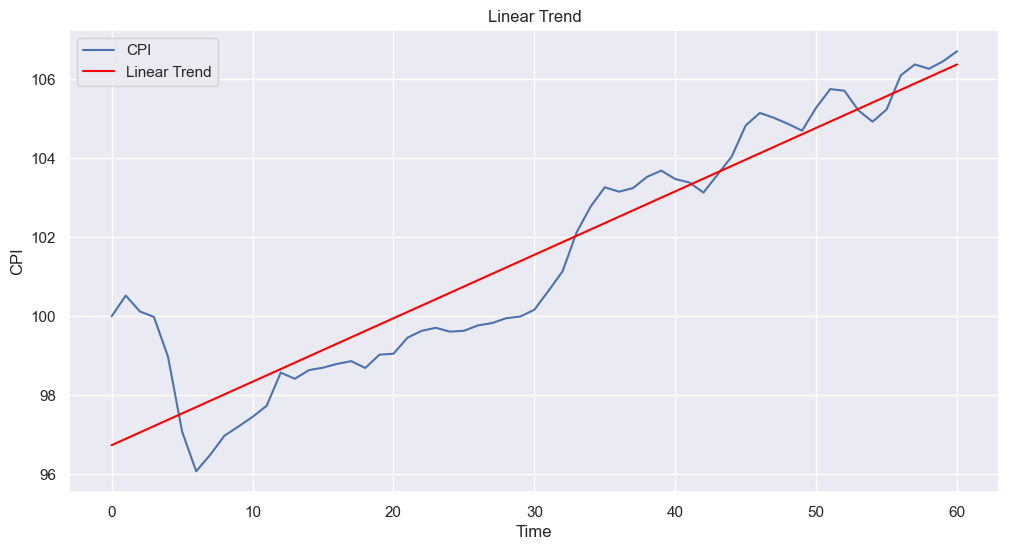

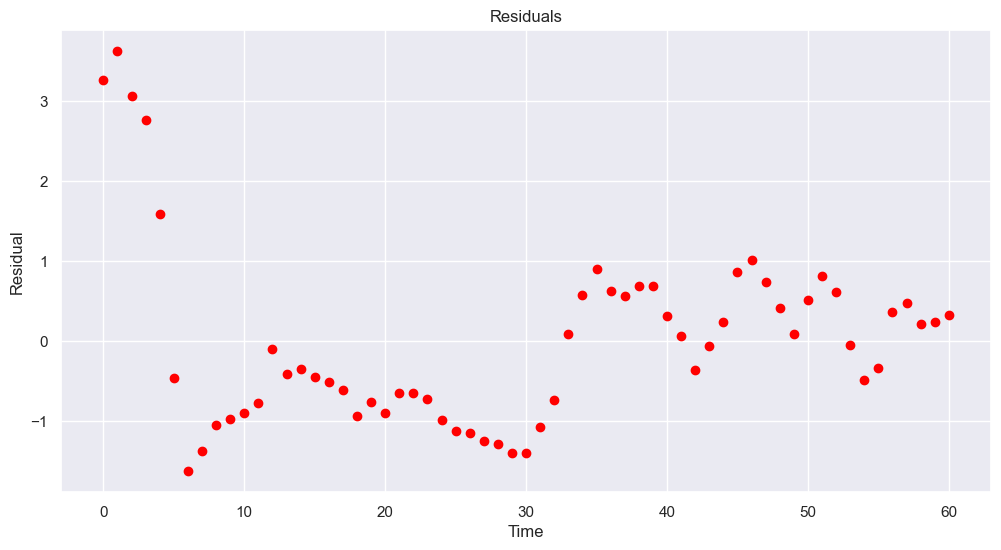

Max Residual 3.6284346102591485


In [4]:
# Set the training data
X = X_train.copy()
y = y_train.copy()

# ================ LINEAR TREND ================ #

# Create a linear regression fit on the data
trend_fit = LinearRegression().fit(X, y)

# Predict the CPI values for the train set
y_pred = trend_fit.predict(X)

# Fetch the coefficients of the linear fit
intercept = trend_fit.intercept_[0]
slope = trend_fit.coef_[0][0]

# Print the coefficients
print("Intercept (alpha 0)", intercept)
print("Slope (alpha 1)", slope)

# Plot the linear trend
plt.figure(figsize=(12, 6))
plt.plot(X, y, label='CPI')
plt.plot(X, y_pred, color='red', label='Linear Trend')
plt.title('Linear Trend')
plt.xlabel('Time')
plt.ylabel('CPI')
plt.legend()
plt.show()

# ================== RESIDUALS ================= #

# Calculate the residuals
residuals = y - y_pred

# Plot the residuals
plt.figure(figsize=(12, 6))
plt.scatter(X, residuals, color='red')
plt.title('Residuals')
plt.xlabel('Time')
plt.ylabel('Residual')
plt.show()

# Get the maximum absolute value of the residuals
max_residual = np.max(np.abs(residuals))
print("Max Residual", max_residual)


### AR Model: Determine the Lag


c:\Users\eddysanoli\AppData\Local\pypoetry\Cache\virtualenvs\data_analysis-ayydRhdv-py3.9\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


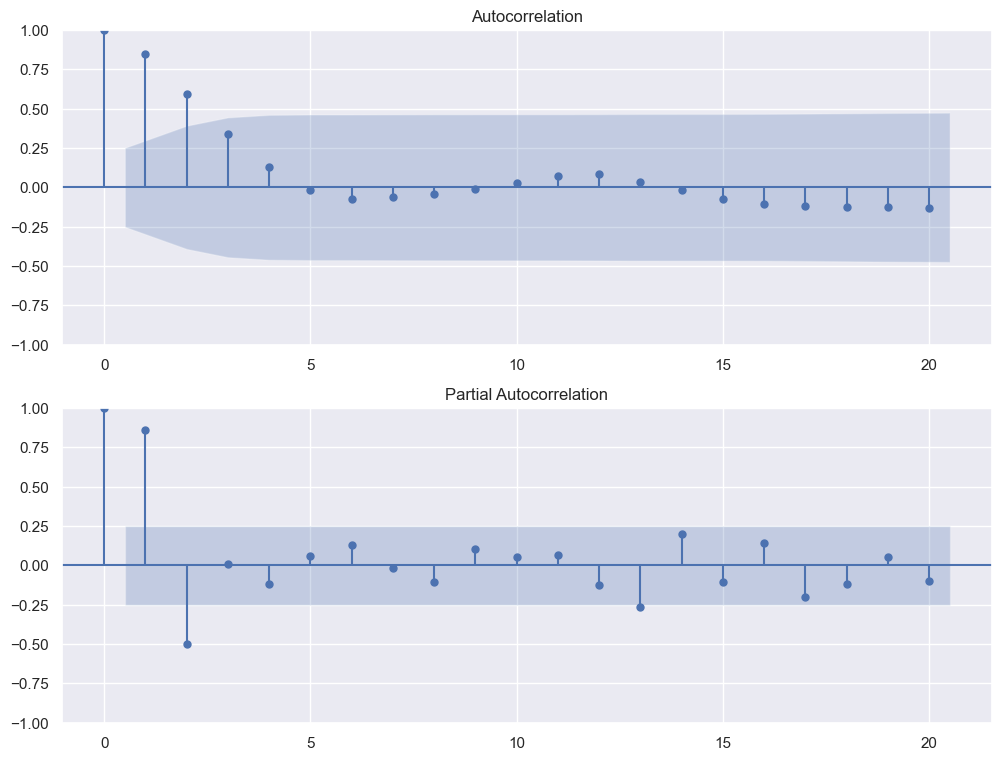

The ACF plot shows a strong correlation for the first 2 lags (they appear 
above the confidence interval), suggesting that the order 'p' of the 
AR model should be 2. The PACF plot won't be used yet, since we are not 
analyzing an MA model yet.


In [5]:
# Plot the ACF and PACF of the residuals
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 9))
plot_acf(residuals, lags=20, ax=ax1)
plot_pacf(residuals, lags=20, ax=ax2)
plt.show()

print("The ACF plot shows a strong correlation for the first 2 lags (they appear ")
print("above the confidence interval), suggesting that the order 'p' of the ")
print("AR model should be 2. The PACF plot won't be used yet, since we are not ")
print("analyzing an MA model yet.")


### AR Model: Find the Parameters


See the 'y.L1' and 'y.L2' coefficients in the summary below for the
phi_1 and phi_2 coefficients of the AR model.

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                   61
Model:                     AutoReg(2)   Log Likelihood                 -17.711
Method:               Conditional MLE   S.D. of innovations              0.327
Date:                Wed, 12 Apr 2023   AIC                             43.422
Time:                        03:25:31   BIC                             51.732
Sample:                             2   HQIC                            46.666
                                   61                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0411      0.043     -0.960      0.337      -0.125       0.043
y.L1           1

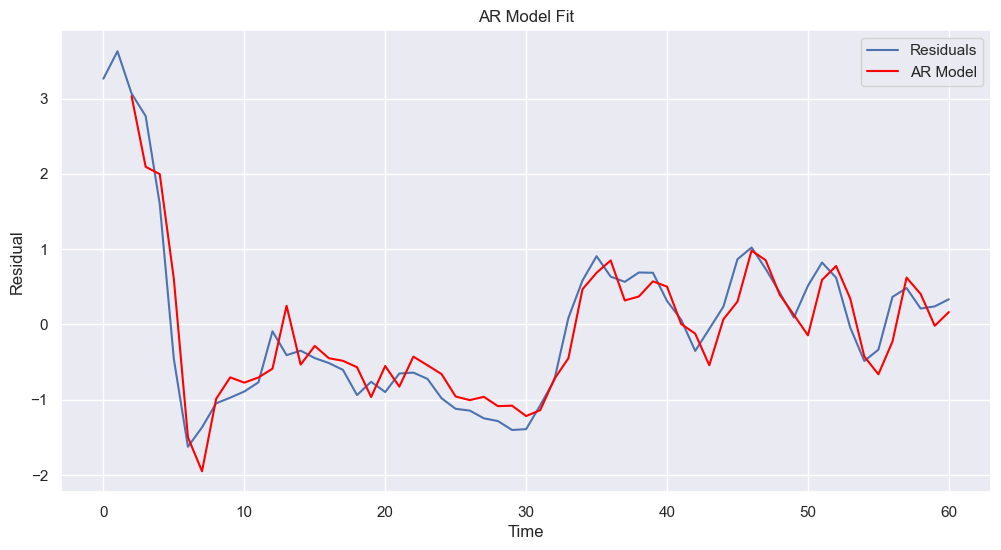

In [6]:
# Fit an AR(2) model on the residuals
p = 2
ar_model = AutoReg(residuals, lags=p, old_names=False).fit()

# Print the summary of the AR model
print("See the 'y.L1' and 'y.L2' coefficients in the summary below for the")
print("phi_1 and phi_2 coefficients of the AR model.")
print()
print(ar_model.summary())

# Plot the AR model predictions
plt.figure(figsize=(12, 6))
plt.plot(X, residuals, label='Residuals')
plt.plot(X, ar_model.predict(), color='red', label='AR Model')
plt.title('AR Model Fit')
plt.xlabel('Time')
plt.ylabel('Residual')
plt.legend()
plt.show()


### Mean Squared Error


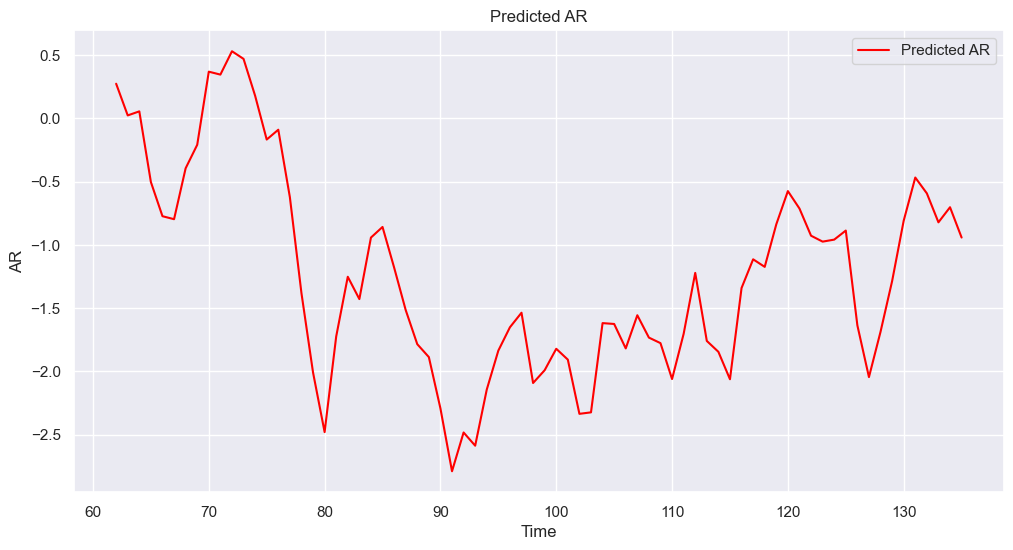

RMSE: 0.38730980891932343


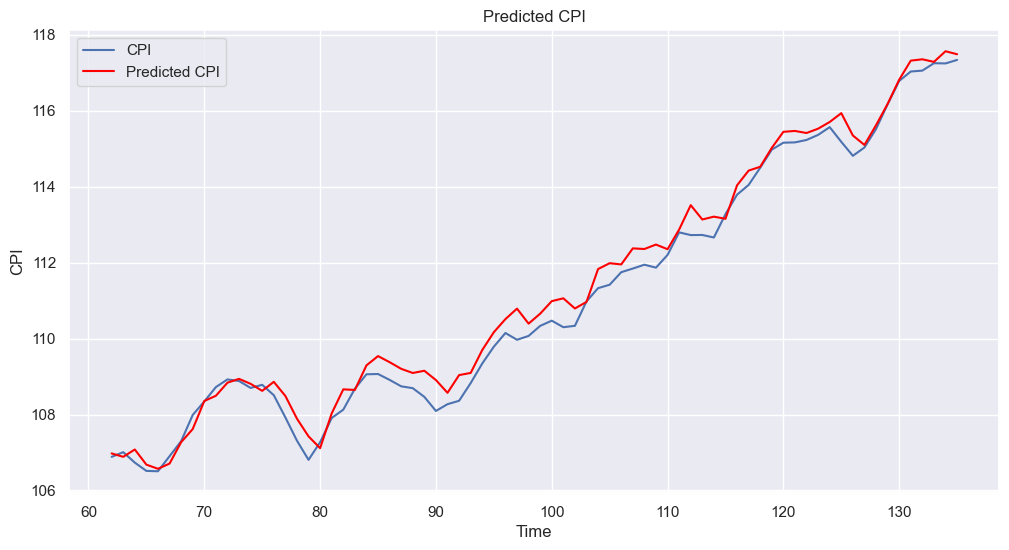

In [7]:
# ================ TREND REMOVAL =============== #

# Predict the CPI trend
y_pred_trend = trend_fit.predict(X_test)

# Remove the trend to calculate the AR predictions
residuals_test = y_test - y_pred_trend

# ===== MANUALLY CALCULATED AR PREDICTIONS ===== #

# Fetch the coefficients of the AR model
epsilon = ar_model.params[0]
phi_1 = ar_model.params[1]
phi_2 = ar_model.params[2]

# Create a new AR dataset:
# - Include the last 2 values from the training set residuals, since they
#   are needed to calculate the first prediction (lag of AR model = 2)
# - Add the residuals calculated for the test set after removing the trend
# - Optional: This last step doesn't make sense to me. You shouldn't be able
#   to add the residuals for the test set, since in a real scenario you wouldn't
#   have access to them, you are trying to predict them. Seems like this is the
#   answer, but I don't understand why. I left commented out the version where
#   instead of including the test residuals, I just add 0s to simulate a real
#   scenario (it even makes more sense, as the test residuals should tend to the
#   mean of the values)
ar_data = np.vstack((residuals[-2:], residuals_test))

# Generate the AR predictions for the test set using the coefficients
y_pred_ar = np.zeros(len(X_test))
for i in range(2, len(ar_data)):

    # Calculate the AR prediction
    y_pred_ar[i - 2] = (
        epsilon +
        phi_1 * ar_data[i - 1] +
        phi_2 * ar_data[i - 2]
    )

    # This only uses the past 2 values to calculate the next prediction.
    # Uncomment to see a similar output to what the AutoReg.predict() method
    # returns.
    # ar_data[i] = y_pred_ar[i - 2]


# ================ PREDICTED AR ================ #

# Plot the predicted AR values
plt.figure(figsize=(12, 6))
plt.plot(X_test, y_pred_ar, color='red', label='Predicted AR')
plt.title('Predicted AR')
plt.xlabel('Time')
plt.ylabel('AR')
plt.legend()
plt.show()

# =========== PREDICTED CPI AND RMSE =========== #

# Flatten predicted values for the trend and the AR model
y_pred_trend = y_pred_trend.flatten()
y_pred_ar = y_pred_ar.flatten()

# Calculate the predicted CPI values by adding the trend and AR
y_pred_cpi = y_pred_trend + y_pred_ar

# Calculate the RMSE of the predictions
rmse = mean_squared_error(
    y_test,
    y_pred_cpi,
    squared=False
)
print("RMSE:", rmse)

# =============== PREDICTION PLOT ============== #

# Plot the predictions
plt.figure(figsize=(12, 6))
plt.plot(X_test, y_test, label='CPI')
plt.plot(X_test, y_pred_cpi, color='red', label='Predicted CPI')
plt.title('Predicted CPI')
plt.xlabel('Time')
plt.ylabel('CPI')
plt.legend()
plt.show()


### Inflation Rate from CPI


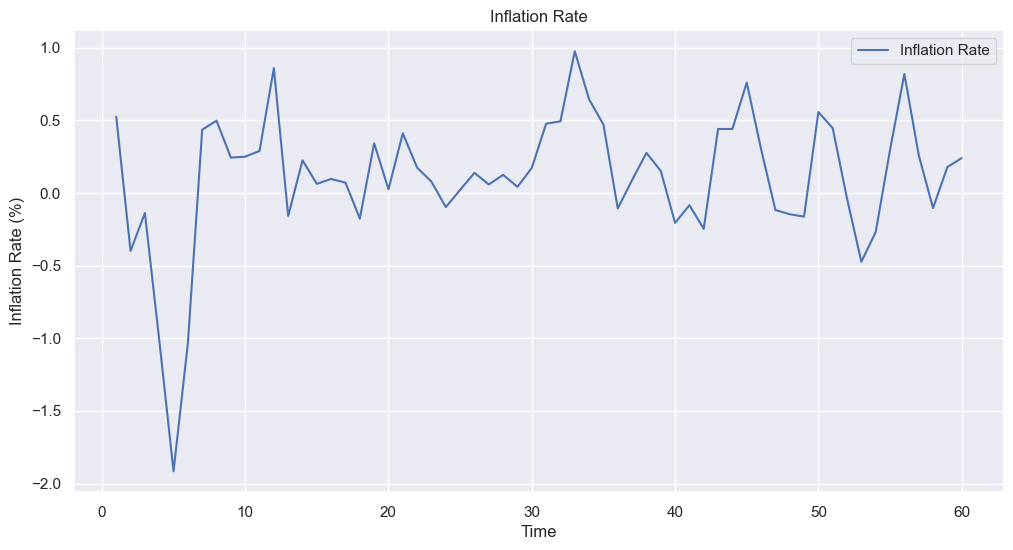

Inflation rate for February 2013: 0.2957229296297584


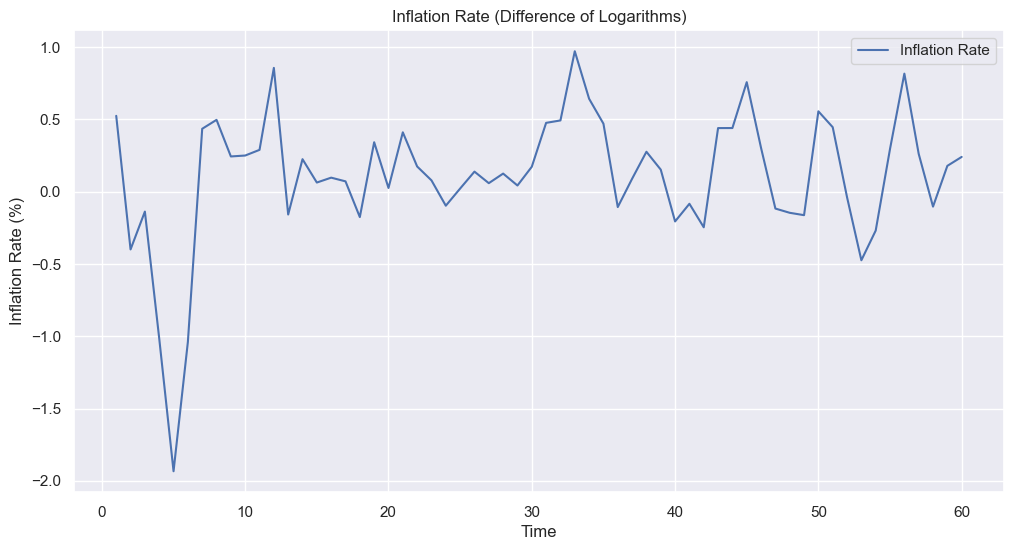

Inflation rate for February 2013 (Difference of Logarithms): 0.2952865295193341


In [8]:
# ============== PERCENTAGE CHANGE ============= #

# Calculate the inflation rate as the percentage change
# between the CPI values
inflation_rate = (np.diff(y, axis=0) / y[:-1]) * 100

# Plot the inflation rate
plt.figure(figsize=(12, 6))
plt.plot(X[1:], inflation_rate, label='Inflation Rate')
plt.title('Inflation Rate')
plt.xlabel('Time')
plt.ylabel('Inflation Rate (%)')
plt.legend()
plt.show()

# Get the index where the second column of the CPI dataset is equal
# to february 2013
february_2013 = pd.to_datetime('2013-02-01')
february_2013_idx = np.where(cpi_array[:, 1] == february_2013)[0][0]

# Subtract 1 from the february 2013 index since the inflation rate
# is calculated as the percentage change between the CPI values
february_2013_idx -= 1

# Get the inflation rate for february 2013
february_2013_inflation_rate = inflation_rate[february_2013_idx]
print("Inflation rate for February 2013:", february_2013_inflation_rate[0])

# ========== DIFFERENCE OF LOGARITHMS ========== #

# Calculate the inflation rate as the difference of logarithms
# between the CPI values
y_log = np.log(np.array(y, dtype=np.float64))
inflation_rate_log = np.diff(y_log, axis=0) * 100

# Plot the inflation rate
plt.figure(figsize=(12, 6))
plt.plot(X[1:], inflation_rate_log, label='Inflation Rate')
plt.title('Inflation Rate (Difference of Logarithms)')
plt.xlabel('Time')
plt.ylabel('Inflation Rate (%)')
plt.legend()
plt.show()

# Get the inflation rate for february 2013
february_2013_inflation_rate_log = inflation_rate_log[february_2013_idx]
print(
    "Inflation rate for February 2013 (Difference of Logarithms):",
    february_2013_inflation_rate_log[0]
)


### Inflation Rate from BER

$$
\text {BER}^{\text {monthly}}_ t = (\text {BER}^{\text {yearly}}_ t +1)^\frac {1}{12} -1
$$


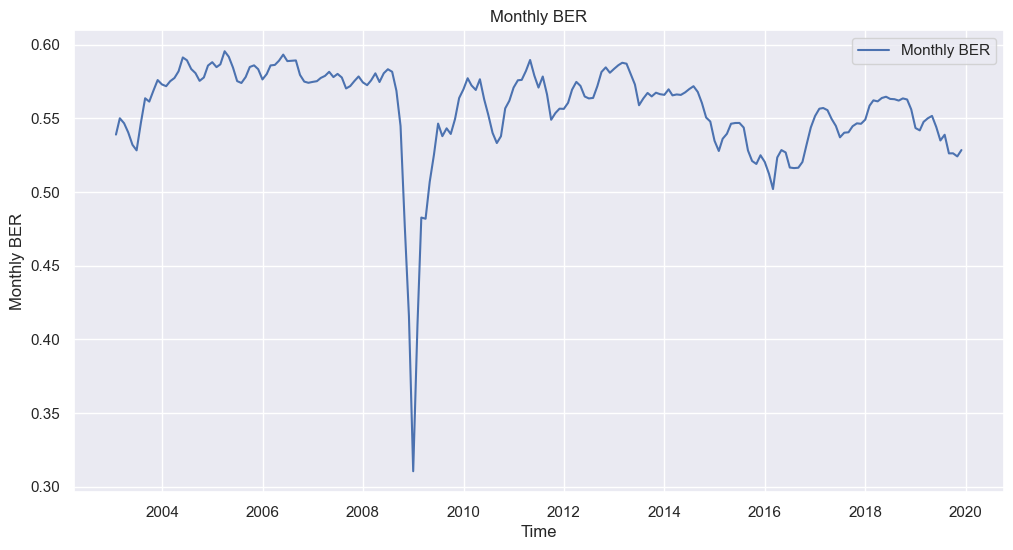

BER for February 2013: 0.5876456124767517


In [22]:
# Load the break-even rate data
df_ber = pd.read_csv('./Datasets/T10YIE.csv')

# Rename the columns of the BER dataset
df_ber.columns = ['date', 'BER']

# Convert the date column to datetime
df_ber['date'] = pd.to_datetime(df_ber['date'])

# Turn the BER column into a percentage by multiplying by 100
# (Dont know why, but ChatGPT suggested it)
df_ber["BER"] = df_ber["BER"] * 100

# We get the average of the BER values over each month as a monthly
# representative
# monthly_representative = df_ber.groupby(
#     pd.Grouper(key='date', freq='MS')
# ).mean()
monthly_representative = df_ber.resample('M', on="date").mean()

# Flatten the headers so that we get 2 regular columns
monthly_representative = monthly_representative.reset_index()

# The monthly representative will be assumed to consist of the
# "BER yearly" value in the formula above. Now we just plug the
# "yearly" value into the formula to get the monthly value
yearly_ber = monthly_representative["BER"].to_numpy()
monthly_ber = (yearly_ber + 1)**(1/12) - 1

# Plot the monthly BER
plt.figure(figsize=(12, 6))
plt.plot(
    monthly_representative['date'],
    monthly_ber,
    label='Monthly BER'
)
plt.title('Monthly BER')
plt.xlabel('Time')
plt.ylabel('Monthly BER')
plt.legend()
plt.show()

# The monthly BER is turned into a percentage by multiplying by 100
# monthly_ber = monthly_ber * 100

# Get the index where the BER date is equal to february 2013
february_2013_idx = np.where(
    monthly_representative['date'] == pd.to_datetime("2013-02-28")
)[0][0]

# Get the BER for february 2013
february_2013_ber = monthly_ber[february_2013_idx]
print("BER for February 2013:", february_2013_ber)
